In [1]:
# dataset used: https://github.com/VildMedPap/countryflags/tree/master

import cv2
import matplotlib.pyplot as plt
import pandas as pd
from cairosvg import svg2png

In [2]:
# read flags.csv
df_flags = pd.read_csv("flags.csv")

In [3]:
df_flags['image_name']
# filenames are ./flags/df_flags['image_name']
filenames_svg = []
filenames = []
for i in range(len(df_flags['image_name'])):
    filenames_svg.append("./flags/" + df_flags['image_name'][i])
    filenames.append("./flags/" + df_flags['image_name'][i].split(".")[0] + ".png")

# sort filenames
filenames.sort()
filenames_svg.sort()

In [4]:
#read images with cairosvg
for i in range(len(filenames)):
    svg2png(url=filenames_svg[i],  write_to=filenames[i], unsafe=True)

In [5]:
# read images with cv2
images = []

for i in range(len(filenames)):
    img = cv2.imread(filenames[i])
    images.append(img)

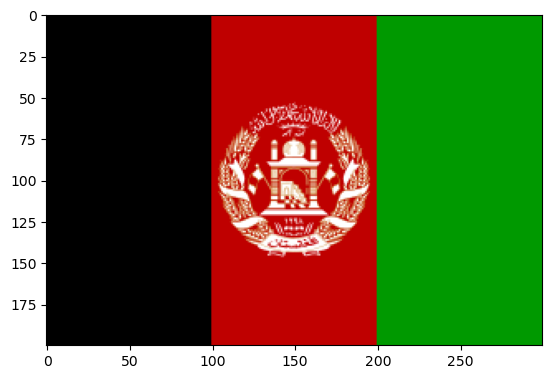

In [6]:
#invert colors as we have bgr instead of rgb
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

# display
plt.imshow(images[0])

In [80]:
# vectorize images using vgg16 pretrained on imagenet
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Using cache found in C:\Users\deus-diabolus/.cache\torch\hub\pytorch_vision_v0.10.0


In [158]:
# use only first 10 layers of vgg16 of the first features module
#model_features = torch.nn.Sequential(*list(model.features.children())[:5])
# use model.features
model_features = model.features
model_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [159]:
# convert images numpy to images pillow
from PIL import Image
images_pil = []
for i in range(len(images)):
    images_pil.append(Image.fromarray(images[i]))

In [160]:
# convert images to tensors of size 256x256
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )])

# convert images to tensor
images_tensor = []
for i in range(len(images_pil)):
    images_tensor.append(transform(images_pil[i]))

In [161]:
# use model as feature extractor
model_features.eval()
images_features = []
for i, image in enumerate(images_tensor):
    with torch.no_grad():
        features = model_features(image.unsqueeze(0))
        images_features.append(features)
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [162]:
# display features as clusters
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [163]:
#each element in images_features is a tensor of size 1x512x8x8 which represents one image
#convert all list elements to a numpy array of size 2 with TSNE for dimensionality reduction and clustering

shape_1, shape_2, shape_3 = images_features[0].shape[1:]

images_features_np = []
for i in range(len(images_features)):
    images_features_np.append(images_features[i].numpy().reshape(shape_1*shape_2*shape_3))

images_features_np = np.array(images_features_np)

# reduce dimensionality to 2
tsne = TSNE(n_components=2, random_state=0)
images_features_np_2d = tsne.fit_transform(images_features_np)


[]

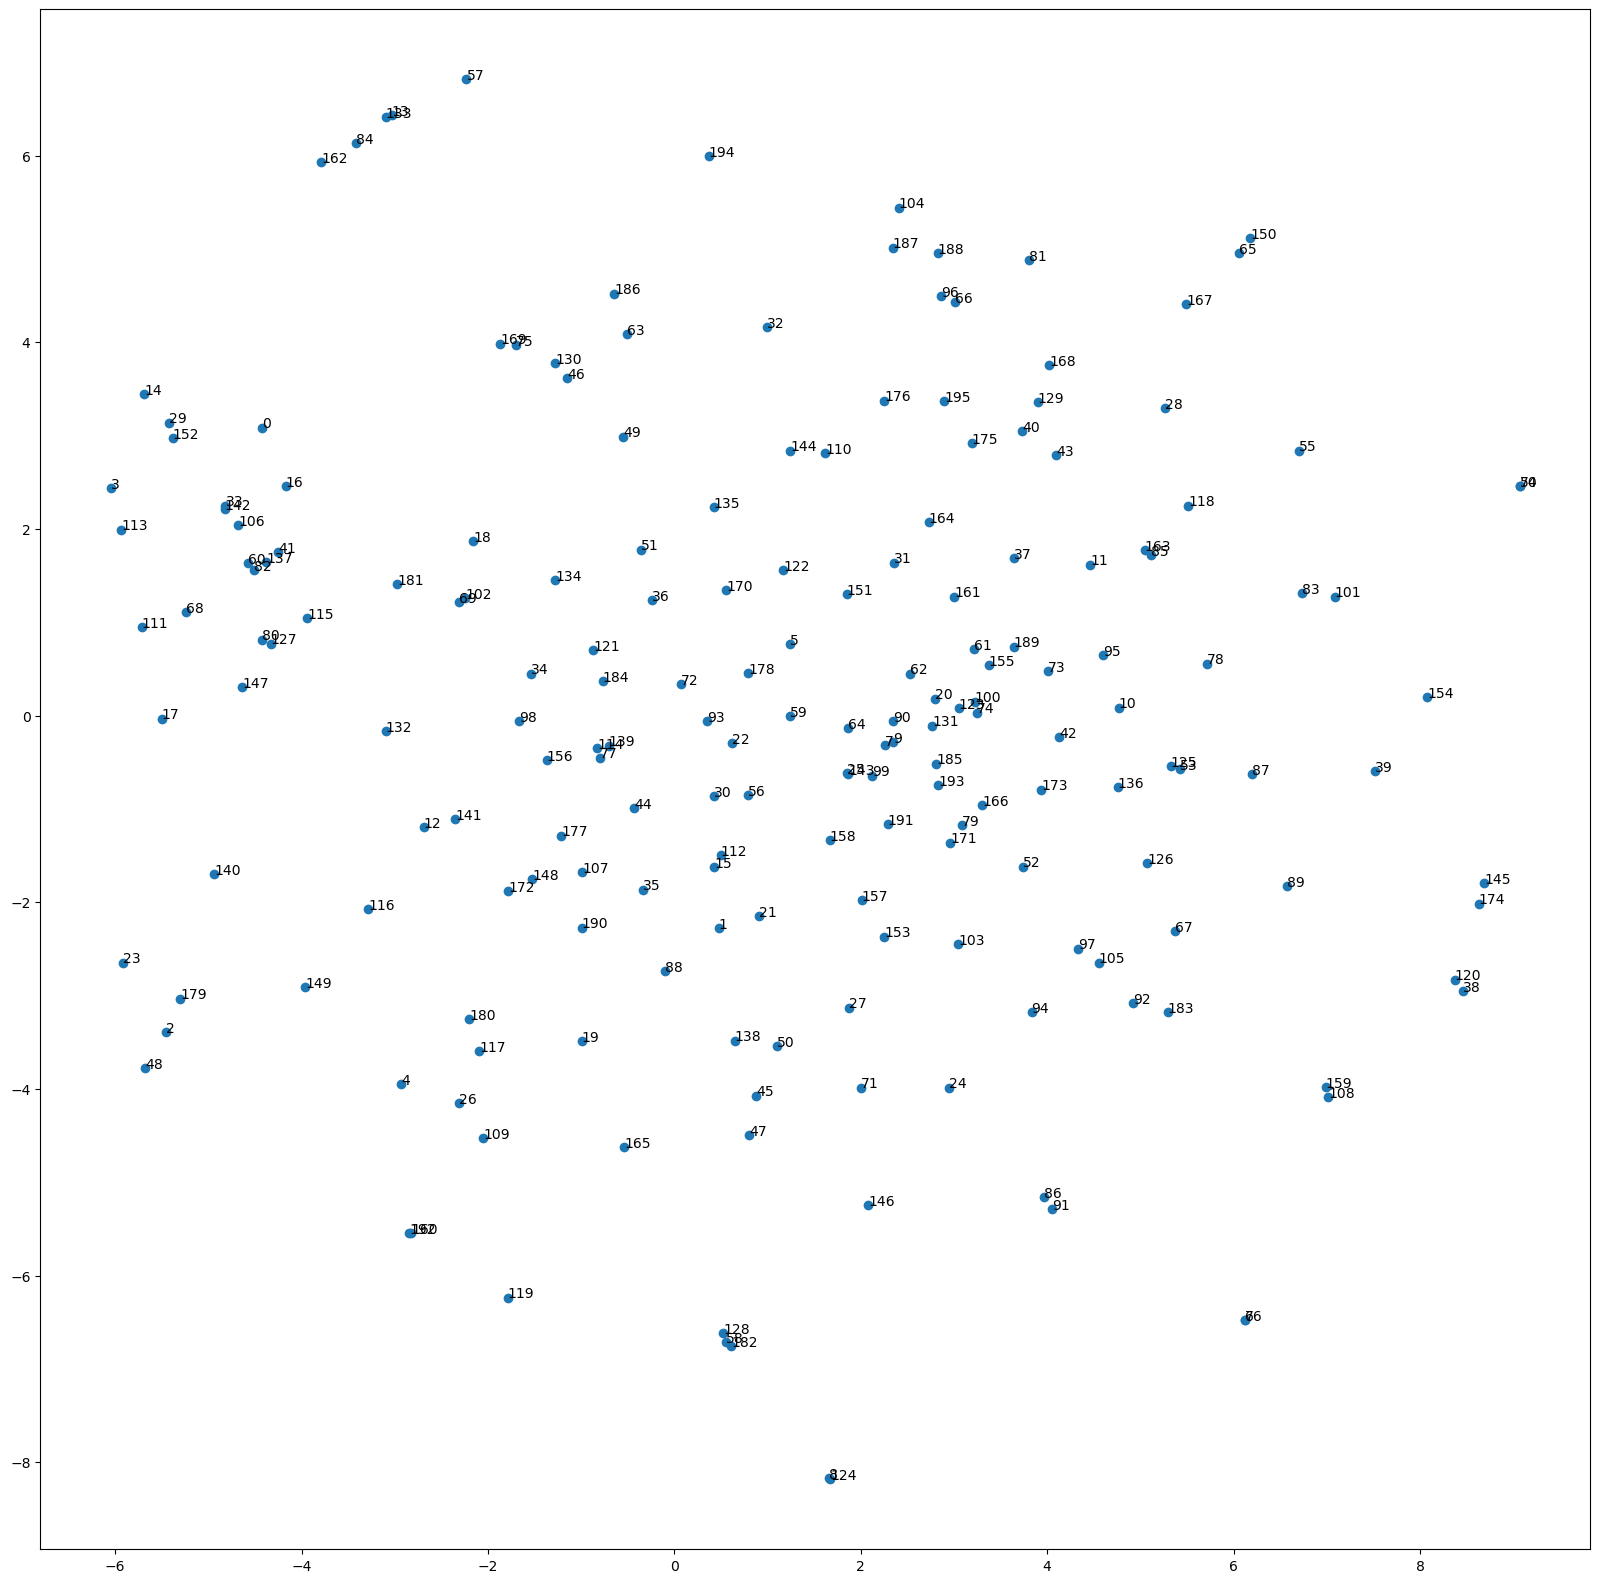

In [174]:
#plot and display index on each dot with only the first 10 layers of the vgg16 feature block is used
x = images_features_np_2d[:,0]
y = images_features_np_2d[:,1]
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y)
for i, txt in enumerate(df_flags['image_name']):
    ax.annotate(i, (x[i], y[i]))
plt.plot()

In [173]:
def display_two_flags(index_1, index_2):
    # given two indices, display the two flags and their respective country names
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(images[index_1])
    ax[1].imshow(images[index_2])
    #title with respective country names
    ax[0].set_title(df_flags['country'][index_1])
    ax[1].set_title(df_flags['country'][index_2])
    plt.show()

In [166]:
# convert country name to index
def get_index(country):
    for i in range(len(df_flags['country'])):
        if df_flags['country'][i] == country:
            return i
    return -1

In [167]:
def get_distance(x, y, index_1, index_2):
    # given two indices and the TSNE reduced dimensionality array, return the euclidean distance between the two points
    return np.sqrt((x[index_1] - x[index_2])**2 + (y[index_1] - y[index_2])**2)

In [201]:
# get closest countries to a given country
def get_closest_countries(country):
    index = get_index(country)
    if index == -1:
        print("Country not found")
        return
    distances = []
    for i in range(len(df_flags['country'])):
        distances.append(get_distance(x, y, index, i))
    # sort distances maintaining the index
    distances = np.array(distances)
    distances_sorted = np.argsort(distances)
    return distances_sorted, distances
    
    

In [262]:
def get_distance_and_flags(index_1, index_2):
    distance = get_distance(x, y, index_1, index_2)
    print("Distance between {} and {} is {}".format(df_flags['country'][index_1], df_flags['country'][index_2], distance))
    display_two_flags(index_1, index_2)

Distance between Andorra and Moldova is 0.4593031084606423
Distance between Andorra and Senegal is 0.8566455729090335
Distance between Andorra and Cameroon is 0.9419879931647228
Distance between Andorra and Barbados is 1.068066067622873
Distance between Andorra and Romania is 1.2428822767398038
Distance between Andorra and Chad is 1.2459052047661177
Distance between Andorra and Mali is 1.4219526815616843
Distance between Andorra and Mexico is 1.5235031279865652
Distance between Andorra and Guatemala is 1.5546611294668646
Distance between Andorra and France is 1.682146050004286


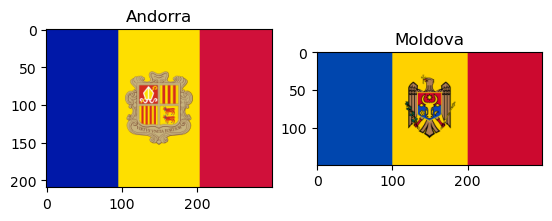

In [260]:
country_1 = "Andorra"
# display closest 10 countries and their distances, ignoring itself
closest_countries, distances = get_closest_countries(country_1)
for i in range(1, 11):
    print("Distance between {} and {} is {}".format(country_1, df_flags['country'][closest_countries[i]], distances[closest_countries[i]]))
#display flag of closest country
get_distance_and_flags(get_index(country_1), get_index(df_flags['country'][closest_countries[1]]))

Distance between Moldova and Spain is 8.663660077299383


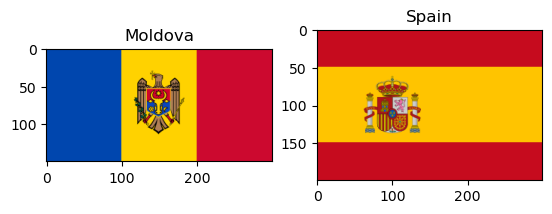

In [263]:
country_1 = "Moldova"
country_2 = "Spain"
get_distance_and_flags(get_index(country_1), get_index(country_2))

In [113]:
#get names of all countries
set(df_flags['country'])

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Denmark',
 'Djibouti',
 'Dominica',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 "Ivory Coast - Côte d'Ivoire",
 'Jamaica',
 

[]

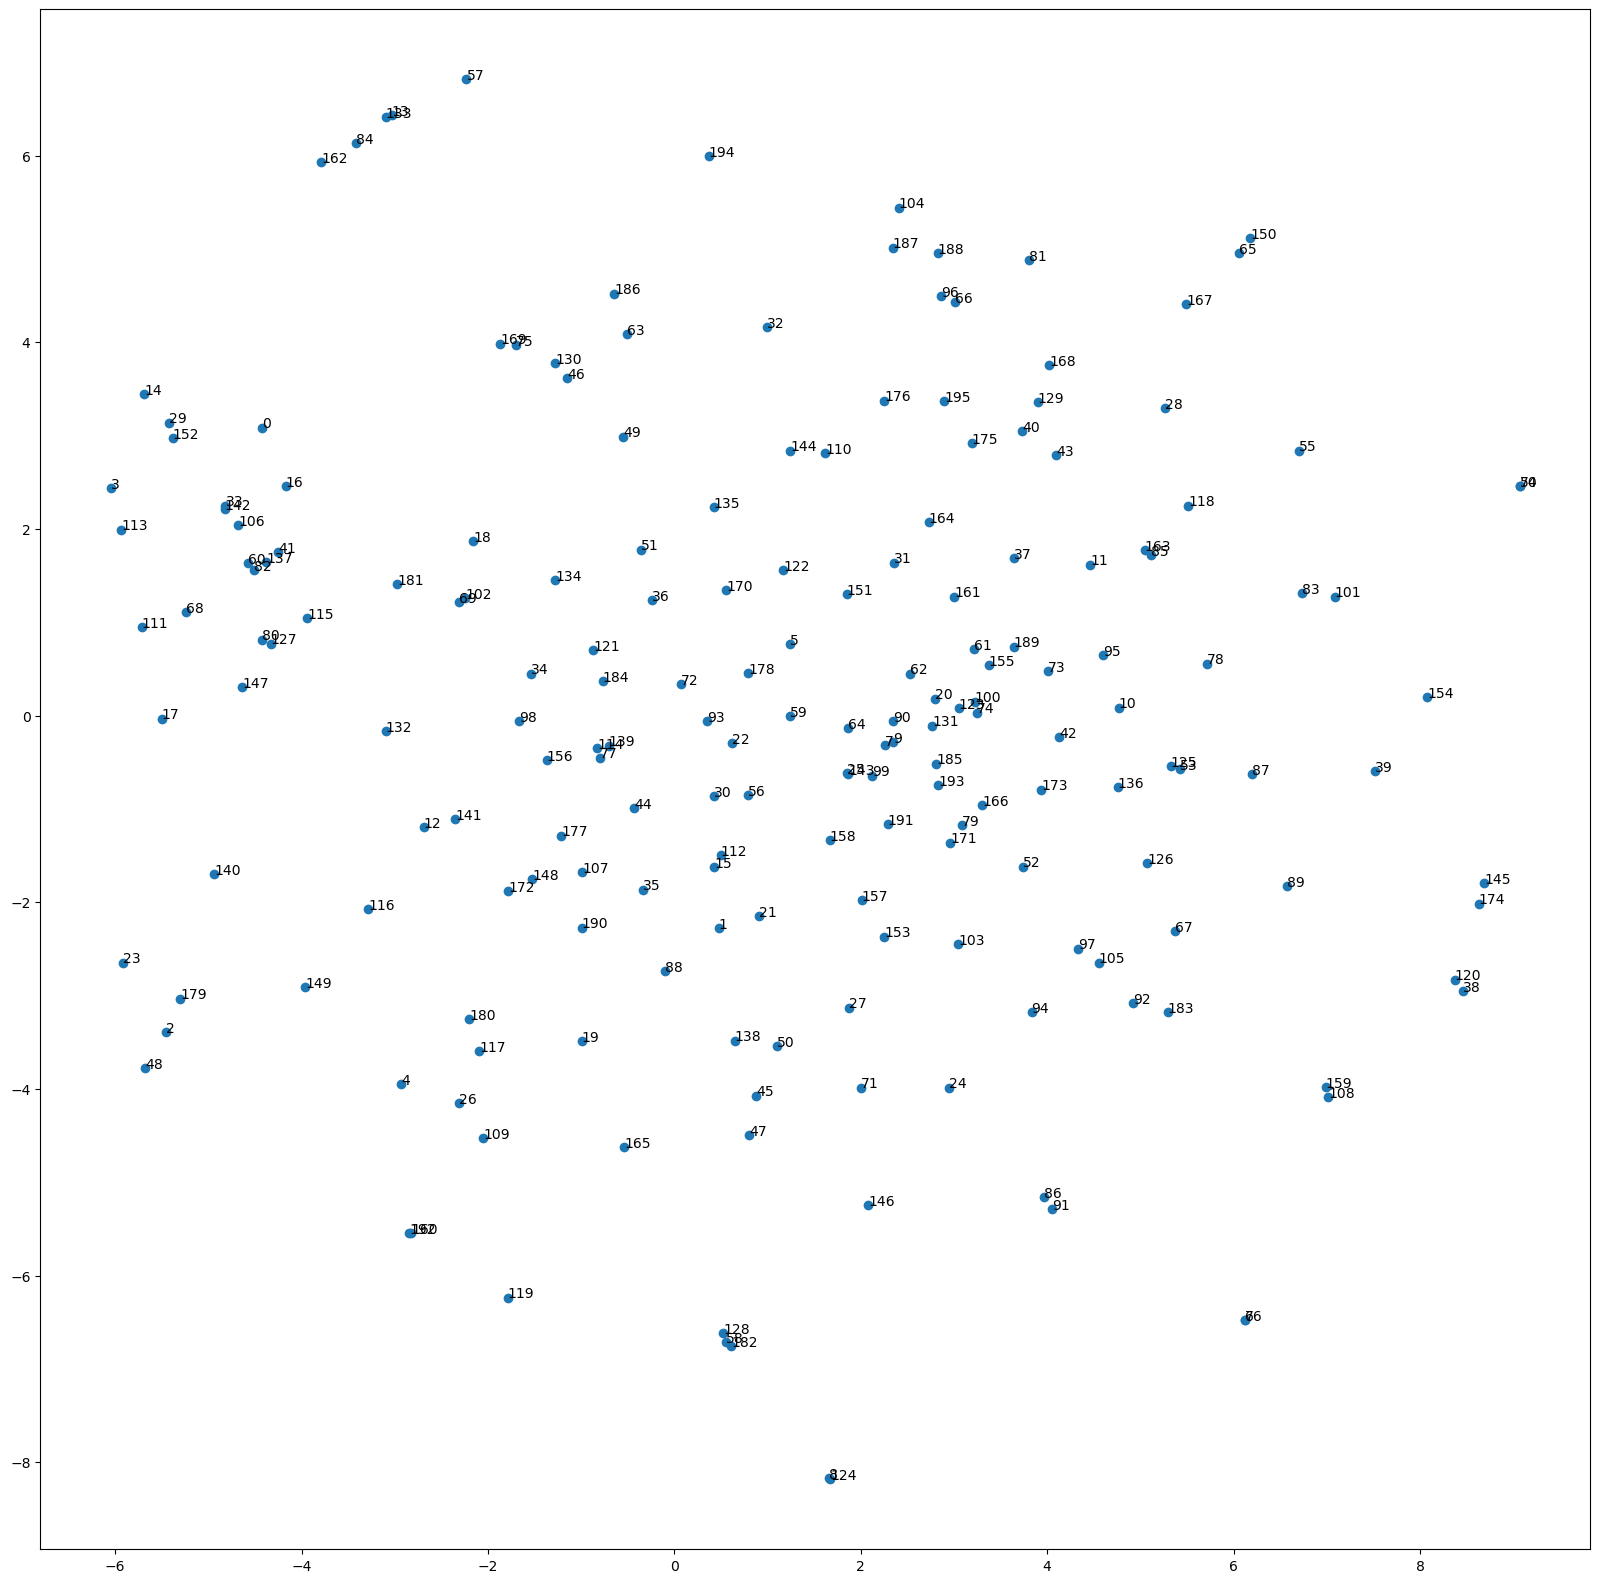

In [68]:
#plot and display index on each dot where the entire feature block of vgg16 is used
x = images_features_np_2d[:,0]
y = images_features_np_2d[:,1]
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y)
for i, txt in enumerate(df_flags['image_name']):
    ax.annotate(i, (x[i], y[i]))
plt.plot()

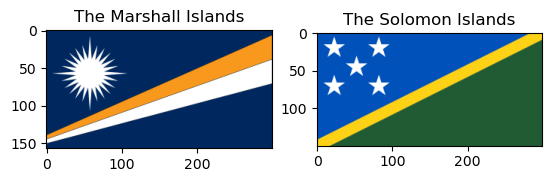

In [71]:
# display images 108, 159 in a subfigure of 2
fig, ax = plt.subplots(1,2)
ax[0].imshow(images[108])
ax[1].imshow(images[159])
#title with respective country names
ax[0].set_title(df_flags['country'][108])
ax[1].set_title(df_flags['country'][159])
plt.show()

In [52]:
# compute distance between feature of image 77 and image 139
import torch.nn.functional as F
#indonesia, poland
distance = F.pairwise_distance(images_features[77], images_features[139])
distance.sum()

tensor(534.3932)

In [51]:
#moldova, andorra
distance = F.pairwise_distance(images_features[3], images_features[113])
distance.sum()

tensor(3400.8291)

In [54]:
#romania, chad
distance = F.pairwise_distance(images_features[142], images_features[33])
distance.sum()

tensor(130.1015)

In [55]:
distance = F.pairwise_distance(images_features[33], images_features[33])
distance.sum()

tensor(0.0116)

In [35]:
#sort df_flags by image_name
df_flags.sort_values(by=['image_name'], inplace=True)
# reset index
df_flags.reset_index(inplace=True)

In [53]:
#get entry of country Indonesia
print(df_flags[df_flags['country'] == 'Romania']['country'])
print(df_flags[df_flags['country'] == 'Chad']['country'])

142    Romania
Name: country, dtype: object
33    Chad
Name: country, dtype: object


In [37]:
df_flags.head()

,index,country,capital,continent,languages,government,population,flag_height,flag_width,flag_colors,...,currency,cet,cest,internet_tld,country_letter_code,country_digit_code,calling_code,borders_to,countryflags_url,image_name
0,39,Afghanistan,Kabul,Asia,Pashto and Dari,Unitary presidential Islamic republic,32564342,2.0,3.0,"['black', 'red', 'green', 'white']",...,afghani (afn),utc+4:30,utc+4:30,af,afg,4,93,"['china', 'iran', 'pakistan', 'tajikistan', 't...",https://www.countryflags.com/en/flag-of-afghan...,afghanistan-flag.svg
1,135,Albania,Tirana,Europe,Albanian,Unitary parliamentary constitutional republic,2891155,5.0,7.0,"['red', 'black']",...,lek (all),utc+01:00,utc+02:00,al,alb,8,355,"['greece', 'kosovo', 'macedonia', 'montenegro']",https://www.countryflags.com/en/flag-of-albani...,albania-flag.svg
2,32,Algeria,Algiers,Africa,Arabic,Unitary semi-presidential republic,40763971,2.0,3.0,"['green', 'white', 'red']",...,dinar (dzd),utc+01:00,utc+01:00,dz,dza,12,213,"['libya', 'mali', 'mauritania', 'morocco', 'ni...",https://www.countryflags.com/en/flag-of-algeri...,algeria-flag.svg
3,184,Andorra,Andorra la Vella,Europe,Catalan,Unitary parliamentary diarchy,72090,7.0,10.0,"['blue', 'red', 'yellow']",...,euro € (eur),utc+01:00,utc+02:00,ad,and,20,376,"['france', 'spain']",https://www.countryflags.com/en/flag-of-andorr...,andorra-flag.svg
4,49,Angola,Luanda,Africa,Portuguese,Unitary presidential republic,26197332,2.0,3.0,"['red', 'yellow', 'black']",...,angolan kwanza kz (aoa),utc+01:00,utc+01:00,ao,ago,24,244,"['congo, democratic republic of the', 'congo, ...",https://www.countryflags.com/en/flag-of-angola...,angola-flag.svg
